# CNN - CrossX - Patch - AWS

### Upload the data required

We use both scans of subjects 1-8 from the PETMR and TRIO dataset for training.

We used the scan of subjects 9-10 also from the PETMR and TRIO dataset for testing.

## FUNCTIONS

In [1]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline
import sys
from dipy.io import read_bvals_bvecs
from dipy.core.gradients import gradient_table

In [2]:
#this function simply uploads the testing and training scans into lists of numpy arrays
#the data is not yet sliced or patched at this stage

#specify in a list what scans to use for training and what scans to use for testing


def get_data(petmr_path, trio_path, scans_dict):
    
    train_data_inp = []
    test_data_inp = []
    train_data_out = []
    test_data_out = []
    paths = [petmr_path, trio_path]
    
    for data_path in paths:
        if(data_path == petmr_path):
            print "Uploading Inputs:"
            training_data_store = train_data_inp
            testing_data_store = test_data_inp
        else:
            print "Uploading Outputs"
            training_data_store = train_data_out
            testing_data_store = test_data_out
        os.chdir(data_path)
        for key, subjs in scans_dict.iteritems():
            for subj_scan in subjs:
                scan_image = nib.load(str(data_path) + "/Subj" + subj_scan + "/Brain_Extracted.nii.gz")
                scan_data = scan_image.get_data()
                #all scans have the same affine mat because registration has already been performed
                #we only need it for saving the predictions as a NIfTI file
                affine_mat = scan_image.affine
                #get b=0 volumes only
                bvals_scan, bvecs_scan = read_bvals_bvecs(str(data_path) + "/Subj" + subj_scan + "/NODDI.bval",\
                                                          str(data_path) + "/Subj" + subj_scan + "/NODDI.bvec")
                #set a threshold value for b=0 values (due to TRIO dataset)
                gtab_scan = gradient_table(bvals_scan, bvecs_scan, b0_threshold=5)
                s0s_scan = scan_data[:, :, :, gtab_scan.b0s_mask]
            
                if(key == "training"):
                    print ("Training: Subj%s" % subj_scan)
                    #append this data to the list containing the training data
                    training_data_store.append(s0s_scan)
                else:
                    print ("Testing: Subj%s" % subj_scan)
                    testing_data_store.append(s0s_scan)
    return (train_data_inp, train_data_out, test_data_inp, test_data_out, affine_mat)

In [10]:
#This function extracts patches from a scan and appends them to a list.
#This is done for all volumes of a scan (for both the inputs and targets)

def patchify(data_scans_inp, data_scans_out, patch_size):
    
    input_patches_store = []
    target_patches_store = []
    
    for scan_no in range(0, len(data_scans_inp)):
        input_scan = data_scans_inp[scan_no]
        target_scan = data_scans_out[scan_no]
        
        (x,y,z,v) = input_scan.shape
        if((patch_size-1) % 2 != 0):
            print "The patch size is not compatible"
            return
        padding = ((patch_size-1)/2)
        #pad the input scan
        full_padding = ((padding, padding), (padding, padding), (padding,padding), (0,0))
        padded_scan = np.pad(input_scan, full_padding, mode='constant', constant_values=0)

        #extract patches from the input scan

        #iterate through each volume to extract the patches
        for volume in range(1):
            for pos_x in range(0, x):
                for pos_y in range(0,y):
                    for pos_z in range(0, z):
                        input_patch = padded_scan[pos_x:pos_x+patch_size, pos_y:pos_y+patch_size, pos_z:pos_z+patch_size, volume]
                        target_voxel = target_scan[pos_x,pos_y,pos_z,volume]

                        #store the patch and the target
                        input_patches_store.append(input_patch)
                        target_patches_store.append(target_voxel)
                    
    return (input_patches_store, target_patches_store)




In [4]:
#This function extracts patches from a scan and appends them to a list.
#This is done for all volumes of a scan (for both the inputs and targets)
#This version of the functions only considers voxels wholly contained within the brain

def patchify_brain_only(data_scans_inp, data_scans_out, patch_size):
    
    input_patches_store = []
    target_patches_store = []
    
    for scan_no in range(0, len(data_scans_inp)):
        input_scan = data_scans_inp[scan_no]
        target_scan = data_scans_out[scan_no]
        
        (x,y,z,v) = input_scan.shape
        if((patch_size-1) % 2 != 0):
            print "The patch size is not compatible"
            return
        padding = ((patch_size-1)/2)
        #pad the input scan
        full_padding = ((padding, padding), (padding, padding), (padding,padding), (0,0))
        padded_scan = np.pad(input_scan, full_padding, mode='constant', constant_values=0)

        #extract patches from the input scan
        #use unpadded scan (original input scan) to identify non-backround voxels

        #iterate through each volume to extract the patches
        for volume in range(1):
            for pos_x in range(0, x):
                for pos_y in range(0,y):
                    for pos_z in range(0, z):
                        if(input_scan[pos_x,pos_y,pos_z,volume] == 0):
                            #this is a background voxel, ignore it
                            continue
                        input_patch = padded_scan[pos_x:pos_x+patch_size, pos_y:pos_y+patch_size, pos_z:pos_z+patch_size, volume]
                        target_voxel = target_scan[pos_x,pos_y,pos_z,volume]

                        #store the patch and the target
                        input_patches_store.append(input_patch)
                        target_patches_store.append(target_voxel)
                    
    return (input_patches_store, target_patches_store)





In [5]:
def normalise(dataset, mean=None, std=None):
    data_array = np.array(dataset)
    if mean==None and std==None:
        #This is the training data
        mean = np.mean(data_array)
        std = np.std(data_array)
    #normalise the data
    data_array = (data_array - mean)/std
    return (data_array, mean, std)

In [48]:
def viz_pred(inputs, predictions, labels, sliceNo):
    plt.figure
    plt.figure(figsize=(10,10))
    plt.subplot(1, 3, 1).set_axis_off()
    plt.imshow(inputs[:,:,sliceNo,0].T, cmap='gray', origin='lower')
    plt.title("Input")
    plt.subplot(1, 3, 2).set_axis_off()
    plt.imshow(predictions[:,:,sliceNo,0].T, cmap='gray', origin='lower')
    plt.title("Predicted")
    plt.subplot(1, 3, 3).set_axis_off()
    plt.imshow(labels[:,:,sliceNo,0].T, cmap='gray', origin='lower')
    plt.title("Target")
    plt.show()

-------------------------------------------------------------------------------------------------------
---

-------------------------------------------------------------------------------------------------------
---



#### Upload the data

In [91]:
#upload the data
petmr_data_path = '/home/ubuntu/project/Dataset/PETMR_data'
trio_data_path = '/home/ubuntu/project/Dataset/TRIO_data'

training_scans = ["1Scan1"]


testing_scans = ["2Scan1"]

(training_data_inp, training_data_out, testing_data_inp, testing_data_out, affine_mat) = \
        get_data(petmr_data_path, trio_data_path, {"training":training_scans, "testing":testing_scans})

print ("Number of scans used for training input: %d" % len(training_data_inp))
print ("Number of scans used for training output: %d" % len(training_data_out))
print ("Number of scans used for testing input: %d" % len(testing_data_inp))
print ("Number of scans used for testing output: %d" % len(testing_data_out))

Uploading Inputs:
Training: Subj1Scan1
Testing: Subj2Scan1
Uploading Outputs
Training: Subj1Scan1
Testing: Subj2Scan1
Number of scans used for training input: 1
Number of scans used for training output: 1
Number of scans used for testing input: 1
Number of scans used for testing output: 1


#### Patchify the data

In [92]:
print "Patchifying training set"
(training_input, training_target) = patchify(training_data_inp, training_data_out, 9)

print "Patchifying testing set"
(testing_input, testing_target) = patchify(testing_data_inp, testing_data_out, 9)

Patchifying training set
Patchifying testing set


In [93]:
print ("Nember of training examples : %d" % len(training_input))
print ("Nember of testing examples : %d" % len(testing_target))

Nember of training examples : 128800
Nember of testing examples : 168300


# PyTorch Functions

In [14]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

In [15]:
#create a dataset class for our data

class MRIdataset(Dataset):
    """MRI b=0 dataset for patches."""

    def __init__(self, input_patches, target_patches, transform=None):
        """
        Args:
            input_patches: Input patches
            target_patches: Corresponding target patches of the input patches
            transform (callable, optional): Optional transform to be applied
            on a sample.
        """
        self.input_patches = input_patches
        self.target_patches = target_patches
        self.transform = transform

    def __len__(self):
        return len(self.input_patches)

    def __getitem__(self, idx):
        input_patch = np.array(self.input_patches[idx])
        target_patch = np.array(self.target_patches[idx])
        sample = {'input': input_patch, 'target': target_patch}
        

        if self.transform:
            sample = self.transform(sample)
            
        return sample


In [16]:
class To_Tensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        inp, out = sample['input'], sample['target']
        
        #first expand dimension because torch expects H x W x D x C
        #currently we only have H x W x D
        aug_inp = np.expand_dims(inp, 3)
        
        #The target is a single voxel,
        #Conver it to an array
        aug_out = np.array([out])

        # swap channel axis because
        # numpy: H x W x D x C
        # torch: C x D x H x W
        aug_inp = aug_inp.transpose((3, 2, 0, 1))
        
        return {'input': torch.Tensor(aug_inp),
                'target': torch.Tensor(aug_out)}



In [29]:
def train(net, training_dataset, trainloader, losses_list, optimizer, criterion, epochs):
    net.train()
    for epoch in range(epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0): #done in batches
            # get the inputs
            inputs = data['input']
            labels = data['target']

            # wrap them in Variable
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize/update weights
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.data[0] #loss is a variable tensor of size 1, we index to get the value out
            if i % 250 == 249:    # print every 250 mini-batches
                print('[%d, %d] Loss = %.5f' % (epoch + 1, i + 1, running_loss/i))
        total_loss = running_loss / i
        losses_list.append(total_loss)
        print('Loss iteration %d = %.5f' % (epoch+1, total_loss ))
        '''   
        test_error = 0
        total = 0
        for test_data in testloader: #batch processing
            test_inputs = test_data['inp']
            test_labels = test_data['out']
            total += len(test_labels)

            test_outputs = net(Variable(test_inputs))

            test_error += (torch.nn.functional.mse_loss(test_outputs.data, test_labels, size_average=False)).data[0]

        test_error /= total
        print('MSE on test data: %f' % (test_error))
        Adam_acc.append(test_error)
        '''
    print('Finished Training')
    return (net, losses_list)

In [18]:
def plt_losses(losses_list):
    plt.figure
    plt.plot(range(1,len(losses_list)+1), losses_list, 'r-')
    plt.xlabel('iteration')
    # Make the y-axis label, ticks and tick labels match the line color.
    plt.ylabel('Loss')
    plt.show()

In [39]:
 def testing_error(net, testloader, loss_type="MSE"):
    net.eval()
    test_error = 0
    total = 0
    for test_data in testloader: #batch processing
        test_inputs = test_data['input']
        test_labels = test_data['target']
        total += 1

        test_inputs, test_labels = Variable(test_inputs.cuda()), Variable(test_labels.cuda())
        
        test_predictions = net(test_inputs)
        
        if(loss_type == "MSE"):
            #Use MSE loss
            test_error += (torch.nn.functional.mse_loss( Variable(test_predictions.data), test_labels)).data[0]
        else:
            test_error += (torch.nn.functional.l1_loss(Variable(test_predictions.data), test_labels)).data[0]
        
    test_error /= total
    return test_error

In [62]:
def get_predictions(net, testloader):
    net.eval()
    for index, test_data in enumerate(testloader):
        test_inputs = test_data['input']
        test_labels = test_data['target']
        if index % 250 == 249:
            print index + 1
        
        test_inputs, test_labels = Variable(test_inputs.cuda()), Variable(test_labels.cuda())

        #store the predictions in a numpy array which we can reshape later
        test_predictions = net(test_inputs)
        if(index == 0):
            predictions = test_predictions.data.cpu().numpy() 

        else:
            predictions = np.concatenate((predictions, test_predictions.data.cpu().numpy()), axis=0)
            
    #convert back to numpy dimensions of (HxWxDxCxNumbExpls)
    predictions = predictions.transpose(3,4,2,1,0)
    return predictions
    

In [21]:
def reconstruct_brain(predictions, dimensions):
    
    size_x = dimensions[0]
    size_y = dimensions[1]
    size_z = dimensions[2]
    size_v = dimensions[3]
    #assume we have given it a single scan to reconstruct
    reconstructed = np.reshape(predictions, [size_v, size_x, size_y, size_z], order='C')
    reconstructed = reconstructed.transpose(1,2,3,0)
    return reconstructed

-------------------------------------------------------------------------------------------------------
---

-------------------------------------------------------------------------------------------------------
---



### Upload the data using pytorch data loaders

In [95]:
training_dataset = MRIdataset(training_input, training_target, transform=transforms.Compose([To_Tensor()]))
testing_dataset = MRIdataset(testing_input, testing_target, transform=transforms.Compose([To_Tensor()]))

In [96]:
trainloader = DataLoader(training_dataset, batch_size=160,
                        shuffle=True, num_workers=8)
testloader = DataLoader(testing_dataset, batch_size=160,
                        shuffle=False, num_workers=8)

### Develop CNN

Conv -> Batch -> Relu -> Conv -> Batch -> Relu -> Conv -> Batch -> Relu -> Conv -> Relu

--(WxHx2x1)--

conv1 = receptive field -> (3x3x3), zero padding -> 2,  number of filters -> 10

--(W+2xH+2x4x10)--

--BATCH then RELU--

conv2 = receptive field -> (1x1x1), number of filters -> 15

--(W+2xH+2x4x15)--

--BATCH then RELU--

conv3 = receptive field -> (3x3x3), number of filters -> 15

--(WxHx2x15)--

--BATCH then RELU--

conv4 = receptive field -> (1x1x2), number of filters -> 1

--(WxHx1x1)--

--RELU--




In [53]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv3d(1, 50, 3)
        self.batch1 = nn.BatchNorm2d(50)
        self.drop1 = nn.Dropout(p=0.2)
        self.conv2 = nn.Conv3d(50, 100, 1)
        self.batch2 = nn.BatchNorm2d(100)
        self.drop2 = nn.Dropout(p=0.2)
        self.conv3 = nn.Conv3d(100, 100, 3)
        self.batch3 = nn.BatchNorm2d(100)
        self.drop3 = nn.Dropout(p=0.2)
        self.conv4 = nn.Conv3d(100, 100, 1)
        self.batch4 = nn.BatchNorm2d(100)
        self.drop4 = nn.Dropout(p=0.2)
        self.conv5 = nn.Conv3d(100, 100, 3)
        self.batch5 = nn.BatchNorm2d(100)
        self.drop5 = nn.Dropout(p=0.2)
        self.conv6 = nn.Conv3d(100, 50, 1)
        self.batch6 = nn.BatchNorm2d(50)
        self.drop6 = nn.Dropout(p=0.2)
        self.conv7 = nn.Conv3d(50, 1, 3)
        
        

    #note this method isn't called explicitly during train, 
    #rather the instance object is called as pytorch is then 
    #able to take care of other stuff in the background
    def forward(self, x):
        x = F.relu(self.batch1(self.conv1(x)))
        x = F.relu(self.batch2(self.conv2(x)))
        x = F.relu(self.batch3(self.conv3(x)))
        x = F.relu(self.batch4(self.conv4(x)))
        x = F.relu(self.batch5(self.conv5(x)))
        x = F.relu(self.batch6(self.conv6(x)))
        x = F.relu(self.conv7(x))
        return x


net = Net()
net.cuda()
print(net)

Net(
  (conv1): Conv3d (1, 50, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (batch1): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True)
  (drop1): Dropout(p=0.2)
  (conv2): Conv3d (50, 100, kernel_size=(1, 1, 1), stride=(1, 1, 1))
  (batch2): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True)
  (drop2): Dropout(p=0.2)
  (conv3): Conv3d (100, 100, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (batch3): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True)
  (drop3): Dropout(p=0.2)
  (conv4): Conv3d (100, 100, kernel_size=(1, 1, 1), stride=(1, 1, 1))
  (batch4): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True)
  (drop4): Dropout(p=0.2)
  (conv5): Conv3d (100, 100, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (batch5): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True)
  (drop5): Dropout(p=0.2)
  (conv6): Conv3d (100, 50, kernel_size=(1, 1, 1), stride=(1, 1, 1))
  (batch6): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True)
  (drop6): Dropout(p=0.2)
  (conv7): Conv3d (50, 1

### Define loss function and optimization algorithm

In [54]:
#here we use MSE loss
criterion = nn.MSELoss() #returns the average over a mini-batch as opposed to the sum
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [55]:
losses = []

### Train CNN

In [57]:
(trained_net, adam_losses) = train(net, training_dataset, trainloader, losses, optimizer, criterion, 15)

[1, 250] Loss = 344.83782
[1, 500] Loss = 361.99766
[1, 750] Loss = 368.12224
Loss iteration 1 = 369.70840
[2, 250] Loss = 335.01836
[2, 500] Loss = 345.28747
[2, 750] Loss = 351.75805
Loss iteration 2 = 352.26390
[3, 250] Loss = 347.10555
[3, 500] Loss = 349.55250
[3, 750] Loss = 352.64812
Loss iteration 3 = 352.78734
[4, 250] Loss = 302.28490
[4, 500] Loss = 316.64380
[4, 750] Loss = 327.26866
Loss iteration 4 = 328.73353
[5, 250] Loss = 318.55979
[5, 500] Loss = 310.42727
[5, 750] Loss = 315.79158
Loss iteration 5 = 317.97968
[6, 250] Loss = 307.03807
[6, 500] Loss = 311.43089
[6, 750] Loss = 307.76246
Loss iteration 6 = 306.33090
[7, 250] Loss = 276.11225
[7, 500] Loss = 278.73029
[7, 750] Loss = 280.23764
Loss iteration 7 = 280.28796
[8, 250] Loss = 269.93750
[8, 500] Loss = 279.20203
[8, 750] Loss = 278.82729
Loss iteration 8 = 278.44540
[9, 250] Loss = 252.81034
[9, 500] Loss = 250.71054
[9, 750] Loss = 255.74424
Loss iteration 9 = 256.50236
[10, 250] Loss = 257.03650
[10, 500] 

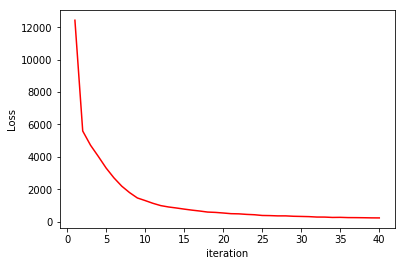

In [58]:
plt_losses(adam_losses)

### Calculate MSE on testing data

In [97]:
test_error_MSE = testing_error(trained_net, testloader, "MSE")
print('MSE on test data: %f' % (test_error_MSE))
print ("Mean error per voxel : %f\n" % \
       (np.sqrt(test_error_MSE)))

test_error_L1 = testing_error(trained_net, testloader, "L1")
print('L1 loss on test data: %f' % (test_error_L1))

MSE on test data: 12022.694795
Mean error per voxel : 109.648050

L1 loss on test data: 51.724157


### Store predictions in a numpy array

In [98]:
predictions = get_predictions(net, testloader)


250
500
750
1000


In [99]:
(x,y,z,v) = testing_data_inp[0].shape

In [100]:
predicted_brain = reconstruct_brain(predictions,[x,y,z,1])

In [101]:
predicted_brain.shape

(51, 66, 50, 1)

### Visualise predictions

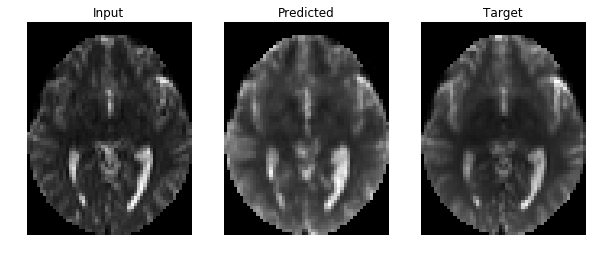

In [103]:
viz_pred(testing_data_inp[0], predicted_brain, testing_data_out[0], 20)

In [104]:
predicted_brain.max()

1216.8916

In [105]:
testing_data_out[0].max()

1870.0

## Save the target and the predicted scans

In [106]:
save_to = "/home/ubuntu/project/Dataset/EXP_AWS_1/Overfit"

predicted_scan = nib.Nifti1Image(predicted_brain, affine_mat)
nib.save(predicted_scan, save_to + "/Predicted_scan_subj2_AWS.nii.gz" )

target_scan = nib.Nifti1Image(testing_data_out[0][:,:,:,0], affine_mat)
nib.save(target_scan, save_to + "/Target_scan_subj2_AWS.nii.gz" )

## Store the model parameters

In [71]:
torch.save(trained_net.state_dict(), '/home/ubuntu/project/MRIDataHarmonisation/Development/Model_Params_AWS/Overfit_AWS.pth') 

## Load the model parameters

In [89]:
trained_net = Net()
trained_net.cuda()
trained_net.load_state_dict(torch.load('/home/ubuntu/project/MRIDataHarmonisation/Development/Model_Params_AWS/Overfit_AWS.pth'))